In this notebook, we do data imputation with MICE (Multiple Imputation with Chained Equations)

# 1. Load data & declare variables

In [1]:
# !pip install impyute

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from impyute.imputation.cs import mice
import xgboost as xgb
import miceforest as mf
from sklearn.metrics import roc_curve, confusion_matrix, auc, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
df = pd.read_csv('../database/2016-2022_semantic_imputation.csv')

In [4]:
binary = ['unequal_voting','classified_board_system','poison_pill','operating_margin_below_3y_average']
non_ratio_variables = [
    "capex",
    "net_capex",
    "short_term_wc",
    "long_term_wc",
    "modified_wc",
    "ebitda",
    "ebit",
    "net_income",
    "net_debt",
    "ev",
    "repurchase",
    "board_size",
    "net_repurchase",
    "total_compensation_to_executives",
    "total_compensation_to_board_members",
    "dividend_to_common",
    "dividend_to_preferred"
]

df['ev_ebitda'] = np.where((df['ev'] != 0) & (df['ebitda'] != 0), df['ev'] / df['ebitda'], np.nan)
df['ev_ebit'] = np.where((df['ev'] != 0) & (df['ebit'] != 0), df['ev'] / df['ebit'], np.nan)

ratio_variables = [
    "ebitda_margin",
    "operating_margin",
    "sales_to_total_assets",
    "roe",
    "normalized_roe",
    "operating_roe",
    "operating_roic",
    "eps_adjusted_diluted",
    "ev_to_sales",
    "tobin_q_ratio",
    "pb_ratio",
    "pe_ratio",
    "fcf_to_equity",
    "sales_growth_rate",
    "dividend_per_share",
    "dividend_payout_ratio",
    "asset_to_equity",
    "cash_conversion_cycle",
    "ev_ebitda",
    "ev_ebit",
]

technical_variables = [
    "free_float_percentage",
    "rsi_14d",
    "rsi_30d",
    "volatility_30d",
    "volatility_90d",
    "volatility_180d",
    "volume_30d_average_to_outstanding",
    "insider_shares_percentage",
    "institution_ownership_percentage",
    "ceo_tenure",
    "total_return_5y",
    "total_return_4y",
    "total_return_3y",
    "total_return_2y",
    "total_return_1y",
    "total_return_6m",
    "total_return_3m",
    "employee_growth_rate",
    "fcf_yield"
]

supportive = ["bic_level_2","bic_level_3","market_cap"]
factors = binary + non_ratio_variables + ratio_variables + technical_variables
# factors.append("targeted")

# 2. Conduct data imputation with MICE forest

In [5]:
df["bic_level_2"] = df["bic_level_2"].astype('category')
df["bic_level_3"] = df["bic_level_3"].astype('category')

In [6]:
df_amp = mf.ampute_data(df[factors], perc = 0.25, random_state = 42)
kds = mf.ImputationKernel(df_amp, save_all_iterations=True, random_state = 42)
kds.mice(10)

In [7]:
df_mf = kds.complete_data()
df_mf = pd.concat([df_mf, df[['year', 'targeted',"market_cap","bic_level_2","bic_level_3"]]], axis=1)

# 3. Run models

In [8]:
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    
def plot_roc_curve(y_true, y_pred, label=None):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    if label:
        plt.legend()

Epoch 1/10
330/330 [==============================] - 0s 812us/step - loss: 0.2086 - accuracy: 0.9639 - val_loss: 0.1138 - val_accuracy: 0.9780
Epoch 2/10
330/330 [==============================] - 0s 610us/step - loss: 0.1705 - accuracy: 0.9650 - val_loss: 0.1083 - val_accuracy: 0.9780
Epoch 3/10
330/330 [==============================] - 0s 591us/step - loss: 0.1638 - accuracy: 0.9649 - val_loss: 0.1073 - val_accuracy: 0.9780
Epoch 4/10
330/330 [==============================] - 0s 598us/step - loss: 0.1603 - accuracy: 0.9649 - val_loss: 0.1062 - val_accuracy: 0.9780
Epoch 5/10
330/330 [==============================] - 0s 594us/step - loss: 0.1555 - accuracy: 0.9649 - val_loss: 0.1142 - val_accuracy: 0.9776
Epoch 6/10
330/330 [==============================] - 0s 590us/step - loss: 0.1535 - accuracy: 0.9646 - val_loss: 0.1092 - val_accuracy: 0.9780
Epoch 7/10
330/330 [==============================] - 0s 592us/step - loss: 0.1528 - accuracy: 0.9651 - val_loss: 0.1093 - val_accuracy:

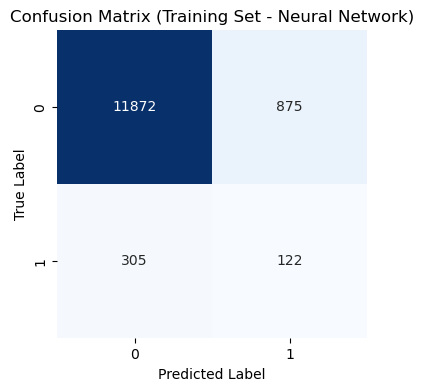

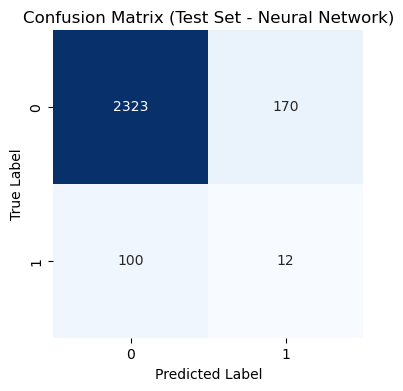

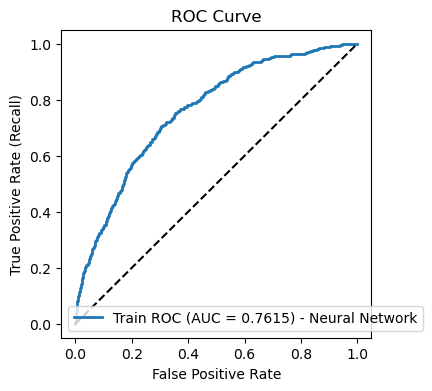

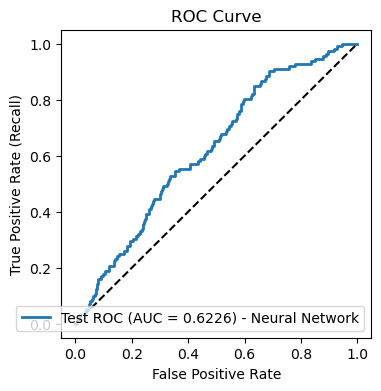

In [9]:
train_data = df_mf[df_mf['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df_mf[df_mf['year'] == 2021]

X_train = train_data[factors]
y_train = train_data['targeted']

X_test = test_data[factors]
y_test = test_data['targeted']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_train_nn = model.predict(X_train_scaled)
y_pred_test_nn = model.predict(X_test_scaled)

cm_train_nn = confusion_matrix(y_train, y_pred_train_nn > 0.1)
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn > 0.1)

plot_confusion_matrix(cm_train_nn, 'Confusion Matrix (Training Set - Neural Network)')
plot_confusion_matrix(cm_test_nn, 'Confusion Matrix (Test Set - Neural Network)')

auc_train_nn = roc_auc_score(y_train, y_pred_train_nn)
auc_test_nn = roc_auc_score(y_test, y_pred_test_nn)

plot_roc_curve(y_train, y_pred_train_nn, label=f"Train ROC (AUC = {auc_train_nn:.4f}) - Neural Network")
plot_roc_curve(y_test, y_pred_test_nn, label=f"Test ROC (AUC = {auc_test_nn:.4f}) - Neural Network")
plt.legend(loc="lower right")
plt.show()


In [10]:
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=14)

In [11]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

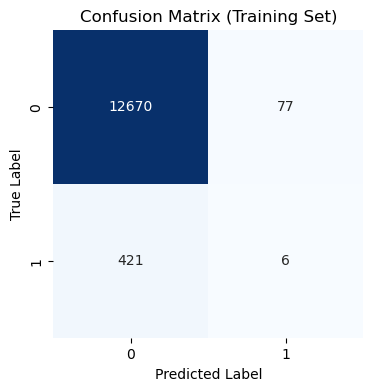

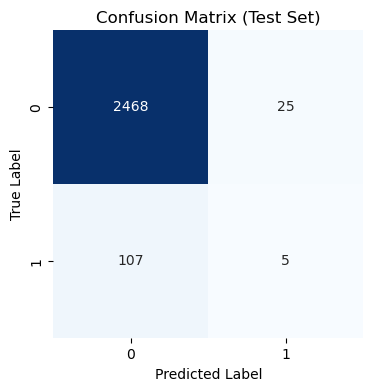

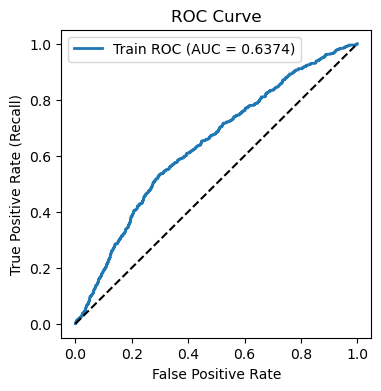

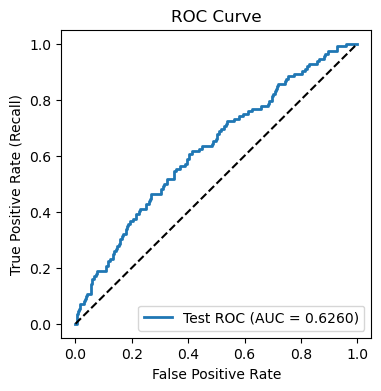

In [12]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()


# 3. Conduct column creation

In [13]:
columns_to_process = [
    "capex",
    "net_capex",
    "short_term_wc",
    "long_term_wc",
    "modified_wc",
    "ebitda",
    "ebit",
    "net_income",
    "net_debt",
    "ev",
    "repurchase",
    "board_size",
    "net_repurchase",
    "total_compensation_to_executives",
    "total_compensation_to_board_members",
    "dividend_to_common",
    "dividend_to_preferred"
]

for col in columns_to_process:
    
    # 1. _percentile
    percentile_col = col + '_percentile'
    df_mf[percentile_col] = df_mf.groupby('year')[col].transform(lambda x: x.rank(pct=True) * 100)
    df_mf[percentile_col].fillna(50, inplace=True)
    
    # 2. _10bins_percentile
    df_mf['market_cap_bins'] = df_mf.groupby('year')['market_cap'].transform(lambda x: pd.cut(x, bins=10))
    percentile_10bins_col = col + '_10bins_percentile'
    df_mf[percentile_10bins_col] = df_mf.groupby(['year', 'market_cap_bins'])[col].transform(lambda x: x.rank(pct=True) * 100)
    df_mf[percentile_10bins_col].fillna(50, inplace=True)
    df_mf.drop('market_cap_bins', axis=1, inplace=True)

    # 3. _10bins_normalized
    df_mf['market_cap_bins'] = df_mf.groupby('year')['market_cap'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
    normalized_col = col + '_10bins_normalized'
    df_mf[normalized_col] = df_mf.groupby(['year', 'market_cap_bins'])[col].transform(lambda x: (x - x.mean()) / x.std())
    df_mf[normalized_col].fillna(0, inplace=True)
    df_mf.drop('market_cap_bins', axis=1, inplace=True)
    
    # 4. _div_market_cap
    div_market_cap_col = col + '_div_market_cap'
    df_mf[div_market_cap_col] = df_mf[col] / df_mf['market_cap']
    
    # 5. _div_log_market_cap
    df_mf['log_market_cap'] = np.log(df_mf['market_cap'])
    div_log_market_cap_col = col + '_div_log_market_cap'
    df_mf[div_log_market_cap_col] = df_mf[col] / df_mf['log_market_cap']
    
    for new_col in [div_market_cap_col, div_log_market_cap_col]:
        median_values = df_mf.groupby('year')[new_col].transform('median')
        df_mf[new_col].fillna(median_values, inplace=True)
    df_mf.drop('log_market_cap', axis=1, inplace=True)

In [14]:
columns_to_process = [
    "ebitda_margin",
    "operating_margin",
    "sales_to_total_assets",
    "roe",
    "normalized_roe",
    "operating_roe",
    "operating_roic",
    "eps_adjusted_diluted",
    "ev_to_sales",
    "tobin_q_ratio",
    "pb_ratio",
    "pe_ratio",
    "fcf_to_equity",
    "sales_growth_rate",
    "dividend_per_share",
    "dividend_payout_ratio",
    "asset_to_equity",
    "cash_conversion_cycle",
    "ev_ebitda",
    "ev_ebit",
]
def compute_percentile(group):
    if len(group) < 10:
        return pd.Series([None] * len(group), index=group.index, dtype=float)
    return group.rank(pct=True) * 100

def normalize(group):
    if len(group) < 10:
        return pd.Series([None] * len(group), index=group.index, dtype=float)
    return (group - group.mean()) / group.std()

for col in columns_to_process:
    percentile_col = col + '_industry_peers_percentile'
    df_mf[percentile_col] = df_mf.groupby(['year', 'bic_level_3'])[col].transform(compute_percentile)
    mask = df_mf[percentile_col].isna()
    df_mf.loc[mask, percentile_col] = df_mf[mask].groupby(['year', 'bic_level_2'])[col].transform(compute_percentile)
    df_mf[percentile_col].fillna(50, inplace=True)
    df_mf[percentile_col] = df_mf[percentile_col].astype(float)
    normalized_col = col + '_industry_peers_normalized'
    df_mf[normalized_col] = df_mf.groupby(['year', 'bic_level_3'])[col].transform(normalize)
    mask = df_mf[normalized_col].isna()
    df_mf.loc[mask, normalized_col] = df_mf[mask].groupby(['year', 'bic_level_2'])[col].transform(normalize)
    df_mf[normalized_col].fillna(0, inplace=True)
    df_mf[normalized_col] = df_mf[normalized_col].astype(float)
    df_mf[col].fillna(df_mf.groupby('year')[col].transform('median'), inplace=True)


In [15]:
new_factors = []
for col in non_ratio_variables:
    new_factors.extend([
        col,
        f'{col}_percentile',
        f'{col}_10bins_percentile',
        f'{col}_10bins_normalized',
        f'{col}_div_market_cap',
        f'{col}_div_log_market_cap'
    ])

for col in ratio_variables:
    new_factors.extend([
        col,
        f'{col}_industry_peers_percentile',
        f'{col}_industry_peers_normalized'
    ])

new_factors = new_factors + binary + technical_variables

# 5. Re-run models

Epoch 1/10
330/330 [==============================] - 0s 864us/step - loss: 0.2058 - accuracy: 0.9581 - val_loss: 0.1072 - val_accuracy: 0.9780
Epoch 2/10
330/330 [==============================] - 0s 720us/step - loss: 0.1757 - accuracy: 0.9646 - val_loss: 0.1109 - val_accuracy: 0.9780
Epoch 3/10
330/330 [==============================] - 0s 721us/step - loss: 0.1662 - accuracy: 0.9647 - val_loss: 0.1055 - val_accuracy: 0.9780
Epoch 4/10
330/330 [==============================] - 0s 663us/step - loss: 0.1568 - accuracy: 0.9647 - val_loss: 0.1063 - val_accuracy: 0.9780
Epoch 5/10
330/330 [==============================] - 0s 640us/step - loss: 0.1558 - accuracy: 0.9650 - val_loss: 0.1045 - val_accuracy: 0.9780
Epoch 6/10
330/330 [==============================] - 0s 642us/step - loss: 0.1518 - accuracy: 0.9647 - val_loss: 0.1065 - val_accuracy: 0.9780
Epoch 7/10
330/330 [==============================] - 0s 640us/step - loss: 0.1465 - accuracy: 0.9648 - val_loss: 0.1061 - val_accuracy:

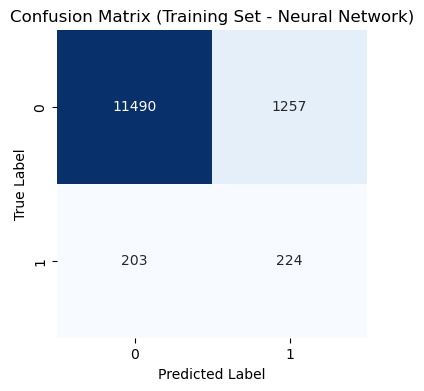

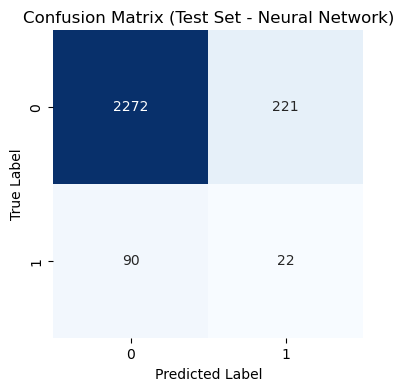

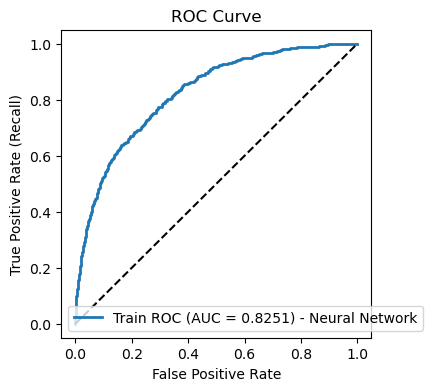

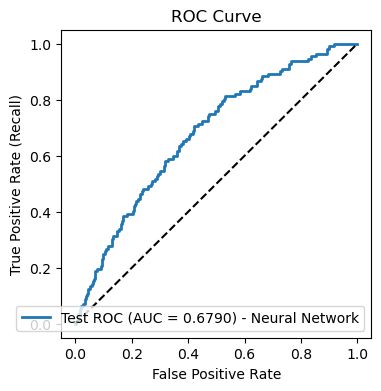

In [16]:
train_data = df_mf[df_mf['year'].isin([2016, 2017, 2018, 2019, 2020])]
test_data = df_mf[df_mf['year'] == 2021]

X_train = train_data[new_factors]
y_train = train_data['targeted']

X_test = test_data[new_factors]
y_test = test_data['targeted']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2)

y_pred_train_nn = model.predict(X_train_scaled)
y_pred_test_nn = model.predict(X_test_scaled)

cm_train_nn = confusion_matrix(y_train, y_pred_train_nn > 0.1)
cm_test_nn = confusion_matrix(y_test, y_pred_test_nn > 0.1)

plot_confusion_matrix(cm_train_nn, 'Confusion Matrix (Training Set - Neural Network)')
plot_confusion_matrix(cm_test_nn, 'Confusion Matrix (Test Set - Neural Network)')

auc_train_nn = roc_auc_score(y_train, y_pred_train_nn)
auc_test_nn = roc_auc_score(y_test, y_pred_test_nn)

plot_roc_curve(y_train, y_pred_train_nn, label=f"Train ROC (AUC = {auc_train_nn:.4f}) - Neural Network")
plot_roc_curve(y_test, y_pred_test_nn, label=f"Test ROC (AUC = {auc_test_nn:.4f}) - Neural Network")
plt.legend(loc="lower right")
plt.show()


In [17]:
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=14)

In [18]:
y_pred_train = cross_val_predict(xgboost_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = xgboost_model.predict_proba(X_test)[:, 1]

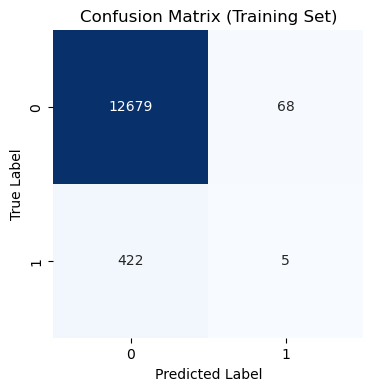

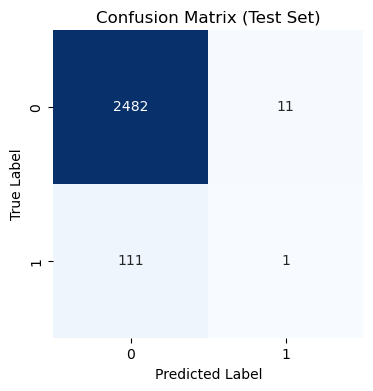

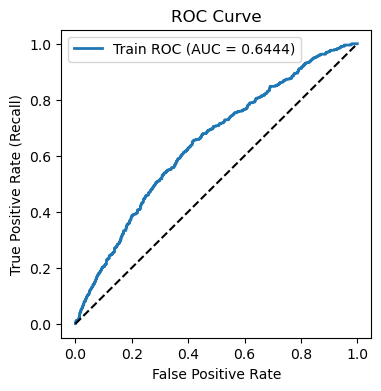

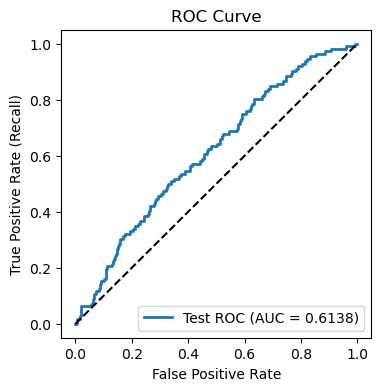

In [19]:
cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()

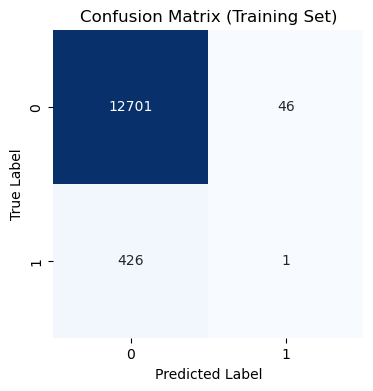

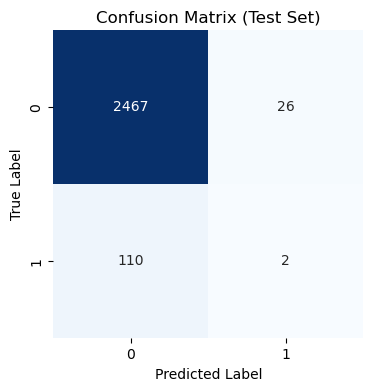

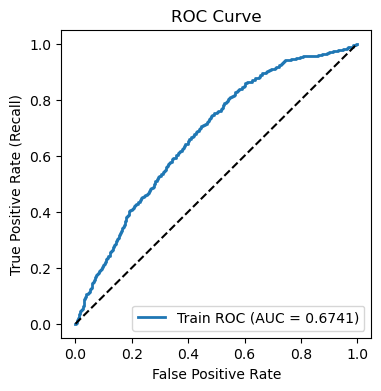

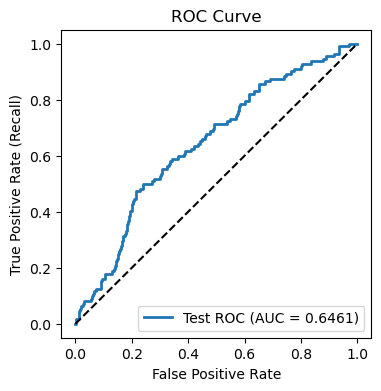

In [20]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=14)

y_pred_train = cross_val_predict(lgb_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = lgb_model.predict_proba(X_test)[:, 1]

cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

# Assuming you have a function to plot confusion matrix
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()


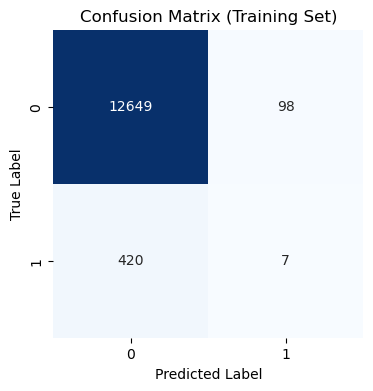

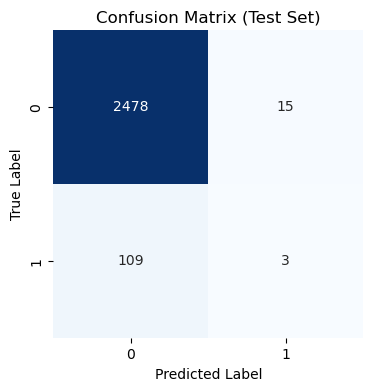

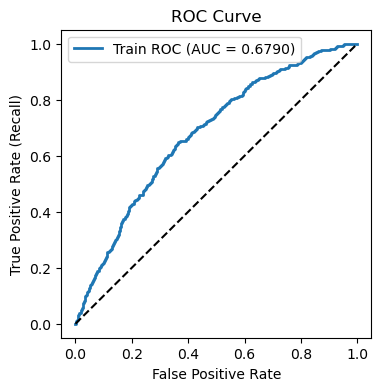

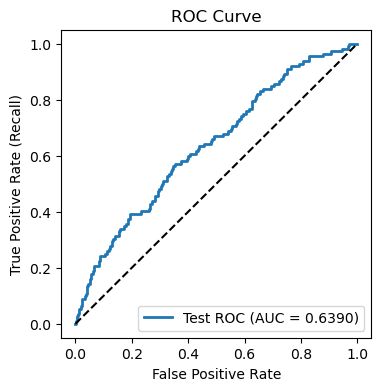

In [21]:
import catboost as cb

# Initialize and train
cb_model = cb.CatBoostClassifier(silent=True)  # silent=True to suppress verbose output
cb_model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=14)

y_pred_train = cross_val_predict(cb_model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
y_pred_test = cb_model.predict_proba(X_test)[:, 1]

cm_train = confusion_matrix(y_train, y_pred_train > 0.1)
cm_test = confusion_matrix(y_test, y_pred_test > 0.1)

# Assuming you have a function to plot confusion matrix
plot_confusion_matrix(cm_train, 'Confusion Matrix (Training Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')

auc_train = roc_auc_score(y_train, y_pred_train)
auc_test = roc_auc_score(y_test, y_pred_test)

plot_roc_curve(y_train, y_pred_train, label=f"Train ROC (AUC = {auc_train:.4f})")
plot_roc_curve(y_test, y_pred_test, label=f"Test ROC (AUC = {auc_test:.4f})")
plt.legend(loc="lower right")
plt.show()
